# Neural Nets for Feature Engineering

This notebook gives an example of using NN to do feature engineering. Specifically, for the Taxi dataset, we might wonder how to encode the time feature. Here we get a NN to learn the model, and then use that to motivate a transformation.

## Imports

In [37]:
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.preprocessing import RobustScaler

import keras
from keras.layers import Input, Embedding, Dense, Dropout, Concatenate
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping

## Load data

In [2]:
file_location = pathlib.Path.cwd() / 'data' / 'taxi_clean_reduced.csv'
taxi_df = pd.read_csv(file_location, parse_dates=['tpep_pickup_datetime'])
taxi_df.head()

,tpep_pickup_datetime,passenger_count,trip_distance,DOLocationID,durations_minutes
0,2018-01-01 00:19:12,2,1.13,161,15.616667
1,2018-01-01 00:58:14,1,3.00,224,17.333333
2,2018-01-01 00:28:40,1,1.10,162,4.500000
3,2018-01-01 00:59:59,1,0.93,237,5.016667
4,2018-01-01 00:25:58,1,3.40,224,20.600000


In [3]:
taxi_df = taxi_df[taxi_df['durations_minutes'] < 1000]

In [4]:
dates = taxi_df.iloc[:, 0]

In [5]:
def second_in_day(series):
    return ((series.dt.hour*60+series.dt.minute)*60+series.dt.second).astype(np.float)

def day_of_week(series):
    return series.dt.dayofweek

## Split into train/test

In [6]:
mask = (taxi_df.iloc[:, 0] < '2018-01-24')
X_train, X_test = taxi_df[mask].drop('durations_minutes', axis=1),\
                  taxi_df[~mask].drop('durations_minutes', axis=1)
y_train, y_test = taxi_df[mask].durations_minutes, taxi_df[~mask].durations_minutes

In [7]:
24*60*60

86400

In [8]:
y_train.shape, y_test.shape

((254680,), (105793,))

In [9]:
x_train_time = np.concatenate([second_in_day(X_train.iloc[:,0]).values.reshape(-1,1)/86400.0, 
                               day_of_week(X_train.iloc[:, 0]).values.reshape(-1,1)/6.0], axis=1)
x_train_other= X_train[['passenger_count', 'trip_distance']].values

## Make a model: functional model

In [10]:
time_input = Input(shape=(2,), dtype='float32', name='time_input')
x = Dense(16, activation='relu', name='layer1')(time_input)
x = Dense(4, activation='relu', name='layer2')(x)
time_output = Dense(1, activation='linear', name='time_output')(x)

In [11]:
other_input = Input(shape=(2,), dtype='float32', name='other_input')
x = keras.layers.concatenate([time_output, other_input])
main_output = Dense(1, activation='linear')(x)

In [12]:
model = Model(inputs=[time_input, other_input], outputs=[main_output])

In [13]:
model.compile(optimizer='adam', loss='mean_squared_error')

### Train the model

In [14]:
history = model.fit([x_train_time, x_train_other], y_train, epochs=25, 
                    validation_split=0.03, callbacks=[EarlyStopping(patience=2)])

Train on 247039 samples, validate on 7641 samples
Epoch 1/25
247039/247039 [==============================] - 11s 44us/step - loss: 48.3549 - val_loss: 18.3811
Epoch 2/25
247039/247039 [==============================] - 11s 43us/step - loss: 35.0316 - val_loss: 16.6448
Epoch 3/25
247039/247039 [==============================] - 11s 43us/step - loss: 34.3052 - val_loss: 16.4798
Epoch 4/25
247039/247039 [==============================] - 11s 43us/step - loss: 34.1860 - val_loss: 16.3677
Epoch 5/25
247039/247039 [==============================] - 11s 43us/step - loss: 34.1118 - val_loss: 16.3972
Epoch 6/25
247039/247039 [==============================] - 11s 43us/step - loss: 34.0595 - val_loss: 16.4238


In [15]:
y_predict = model.predict([x_train_time, x_train_other])

## Check model predictions on random subset

In [23]:
selection = np.random.random(size=(x_train_time.shape[0],)) < 0.01
print(f"Looking at {selection.sum()} samples in plot")

y_train_predict = model.predict([x_train_time[selection,:], x_train_other[selection,:]])

2542

(-50, 50)

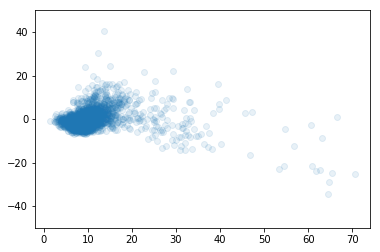

In [27]:
plt.plot(y_train_predict, y_train[selection] - y_train_predict.reshape(-1,), 'o', alpha=0.1)
plt.ylim(-50,50)

## Use a piece of the functional model

Let's isolate the section of the network that deals with the time inputs. This should give us a feature that takes th e time information and turns it into a single feature for use "downstream".

In [ ]:
time_model = Model(inputs=model.input[0], outputs=[model.get_layer('time_output').output])

In [17]:
time_model.predict(x_train_time[-10:])

array([[-1.3463823],
       [-1.5925716],
       [-1.5398624],
       [-1.4910517],
       [-1.5557312],
       [-1.5957273],
       [-1.3695811],
       [-1.3146689],
       [-1.8649305],
       [-0.9597399]], dtype=float32)

In [18]:
for layer in time_model.get_weights():
    print(layer.shape, layer)

(2, 16) [[ 1.1006202  -0.59126     0.7817453  -0.19318482 -1.0560261   0.67028785
   0.8089793   0.7041384  -0.05405968 -0.1600059  -0.48562428 -0.15013134
  -0.6641962   0.53671956 -0.03785473 -0.06396657]
 [-0.38312995  0.04411672  0.15413754 -0.42213166 -0.01427114  0.36972877
  -0.455643    0.5211218  -0.51342744 -0.14241186 -0.21350363  1.0713625
   0.12381898 -0.40203768 -0.44977364  0.35644022]]
(16,) [-0.36034125  0.40070915 -0.5608934   0.          0.39051455  0.11247352
  0.16503797  0.12347531  0.          0.21427883  0.         -0.61570156
  0.41773477  0.2657175   0.          0.14661647]
(16, 4) [[-1.8763926  -0.2276423  -1.5538567  -1.4031215 ]
 [ 0.37175065 -0.11826763 -0.73615617 -0.8940311 ]
 [-1.8728302  -0.4939269  -2.3833761  -1.5707208 ]
 [ 0.4229197  -0.43980125  0.1301558   0.21825045]
 [ 0.15076193 -0.38810956 -3.4757812  -4.2842336 ]
 [ 0.44257054  0.09259248  0.28451464  0.26136485]
 [ 0.4776318  -0.22091523  0.08642041  0.24201648]
 [ 0.62056214 -0.10716811  

In [19]:
time_model.predict(np.array([[0,0]]))

array([[-0.924467]], dtype=float32)

In [20]:
def do_prediction(X):
    X = X.copy()
    for layer in time_model.get_weights():
        if len(layer.shape) == 1:
            X = X + layer
        else:
            X = X @ layer 
    return X

In [21]:
do_prediction(x_train_time[:10])

array([[-7.89769523],
       [-8.05327511],
       [-7.93542767],
       [-8.06025029],
       [-7.92466595],
       [-7.89224794],
       [-7.96638421],
       [-7.93323547],
       [-7.94080853],
       [-7.91968367]])

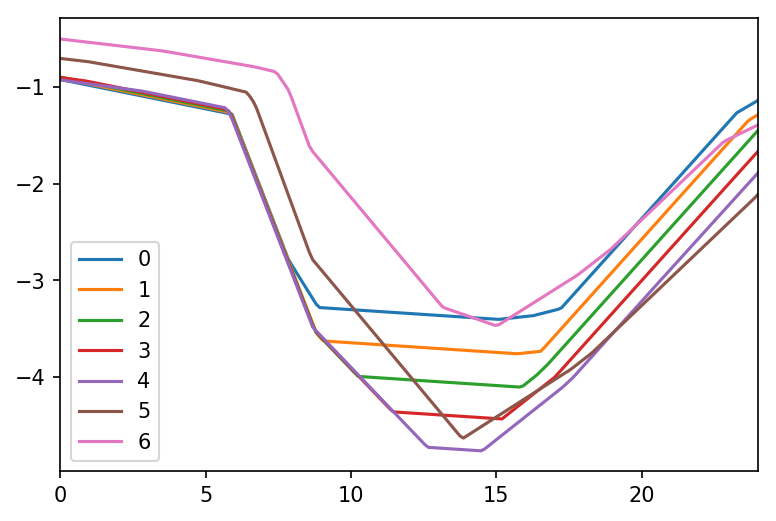

In [22]:
plt.figure(dpi=150)

for day in range(7):
    Xa = np.concatenate([np.linspace(0,1,200).reshape(-1,1), np.ones((200,1))*day/7], axis=1)
    y = time_model.predict(Xa)
    plt.plot(Xa[:, 0]*24, y, label=day)

plt.xlim(0,24)
plt.legend()

In [28]:
np.max(x_train_time[:, 1])

1.0

## simple model

In [29]:
X = np.linspace(0,2,400)
y = 3*X**2 -2*X + np.random.random(size=(400,))
X = X.reshape(-1,1)

In [30]:
m = Sequential()
m.add(Dense(1024, input_shape=(1,), activation='relu'))
m.add(Dense(64, activation='relu'))
m.add(Dense(32, activation='sigmoid'))
m.add(Dense(16, activation='relu'))
m.add(Dense(8, activation='relu'))
m.add(Dense(1, activation='linear'))


In [31]:
m.compile(optimizer='adam', loss='mean_squared_error')

In [32]:
m.fit(X, y, epochs=50, 
      validation_split=0.03)

Train on 388 samples, validate on 12 samples
Epoch 1/50
388/388 [==============================] - 1s 2ms/step - loss: 9.3208 - val_loss: 56.7235
Epoch 2/50
388/388 [==============================] - 0s 347us/step - loss: 7.2103 - val_loss: 44.2578
Epoch 3/50
388/388 [==============================] - 0s 347us/step - loss: 5.1385 - val_loss: 32.7877
Epoch 4/50
388/388 [==============================] - 0s 342us/step - loss: 4.2412 - val_loss: 27.4937
Epoch 5/50
388/388 [==============================] - 0s 346us/step - loss: 3.9047 - val_loss: 26.3204
Epoch 6/50
388/388 [==============================] - 0s 342us/step - loss: 3.5061 - val_loss: 24.3767
Epoch 7/50
388/388 [==============================] - 0s 344us/step - loss: 3.0797 - val_loss: 22.3058
Epoch 8/50
388/388 [==============================] - 0s 344us/step - loss: 2.6280 - val_loss: 18.7076
Epoch 9/50
388/388 [==============================] - 0s 345us/step - loss: 2.2089 - val_loss: 17.1998
Epoch 10/50
388/388 [=========

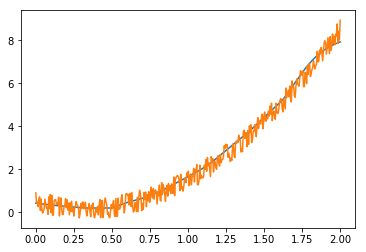

In [33]:
plt.plot(X, m.predict(X))
plt.plot(X, y)

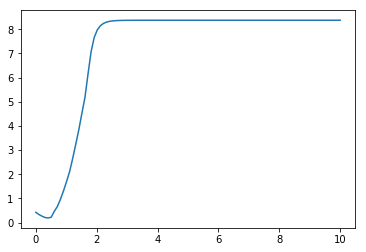

In [34]:
Xtrapolate = np.linspace(0,10,100)
plt.plot(Xtrapolate, m.predict(Xtrapolate))